In [ ]:
# https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(), # 0~1
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))] # -1~1 (RGB평균, RGB표준편차)
)

In [14]:
batch_size = 4
train_data = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

test_data = torchvision.datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

In [15]:
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

In [16]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [93]:
imgs = np.array([img.numpy() for img, _ in train_data])

In [104]:
imgs.shape

(50000, 3, 32, 32)

In [130]:
for rgb in range(3):
    print(f'rgb:{rgb}')
    print(f'- min:{np.min(imgs[:,rgb])}')
    print(f'- max:{np.max(imgs[:,rgb])}')
    print(f'- mean:{np.mean(imgs, axis=(2,3))[:,rgb].mean()}')
    print(f'- std:{np.std(imgs, axis=(2,3))[:,rgb].std()}')

rgb:0
- min:-1.0
- max:1.0
- mean:-0.01720062457025051
- std:0.12105679512023926
rgb:1
- min:-1.0
- max:1.0
- mean:-0.03568316251039505
- std:0.12224994599819183
rgb:2
- min:-1.0
- max:1.0
- mean:-0.10693816095590591
- std:0.1352902352809906


In [147]:
def imshow(img):
    img = img/2+0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [135]:
images.shape

torch.Size([4, 3, 32, 32])

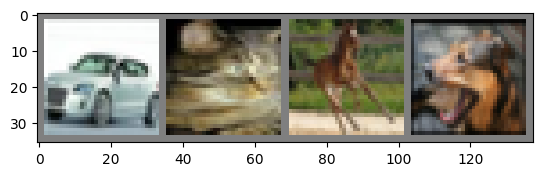

car   cat   horse dog  


In [150]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [205]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=0)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.mlp1 = nn.Linear(12*6*6, 144)
        self.mlp2 = nn.Linear(144, 72)
        self.mlp3 = nn.Linear(72, 10)

    def forward(self, x):
        # print(f'raw : {x.shape}')
        x = self.maxpool(F.relu(self.conv1(x)))
        # print(f'1st pool : {x.shape}')
        x = self.maxpool(F.relu(self.conv2(x)))
        # print(f'2nd pool : {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'flatten : {x.shape}')
        x = F.relu(self.mlp1(x))
        # print(f'1st mlp : {x.shape}')
        x = F.relu(self.mlp2(x))
        # print(f'2nd mlp : {x.shape}')
        x = self.mlp3(x)
        # print(f'3rd mlp : {x.shape}')
        return x

model = CNN()
# if device = 'GPU'
# model.to(device)
        

In [206]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [207]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # if device = 'GPU'
        # X = X.to(device)
        # y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        # if device = 'GPU'
        # X = X.to(device)
        # y = y.to(device)
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):0.1f}%, Avg loss: {test_loss:>8f} \n')
        
    

In [208]:
res = []
for t in range(10):
    print(f'Epoch {t+1}\n------------------------------')
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    res.append([t, loss])
print('Done!')

Epoch 1
------------------------------
loss: 2.269149  [    4/50000]
loss: 2.333828  [ 4004/50000]
loss: 2.312250  [ 8004/50000]
loss: 2.071927  [12004/50000]
loss: 2.283729  [16004/50000]
loss: 1.728028  [20004/50000]
loss: 2.425319  [24004/50000]
loss: 1.432769  [28004/50000]
loss: 1.527803  [32004/50000]
loss: 1.547268  [36004/50000]
loss: 2.248689  [40004/50000]
loss: 1.430280  [44004/50000]
loss: 1.671967  [48004/50000]
Test Error: 
 Accuracy: 46.1%, Avg loss: 1.489722 

Epoch 2
------------------------------
loss: 1.435959  [    4/50000]
loss: 1.198345  [ 4004/50000]
loss: 1.135155  [ 8004/50000]
loss: 1.344626  [12004/50000]
loss: 1.919146  [16004/50000]
loss: 1.199922  [20004/50000]
loss: 1.471695  [24004/50000]
loss: 1.810499  [28004/50000]
loss: 1.126265  [32004/50000]
loss: 1.285106  [36004/50000]
loss: 0.869296  [40004/50000]
loss: 1.864350  [44004/50000]
loss: 2.553609  [48004/50000]
Test Error: 
 Accuracy: 52.7%, Avg loss: 1.313328 

Epoch 3
------------------------------

Text(0, 0.5, 'loss')

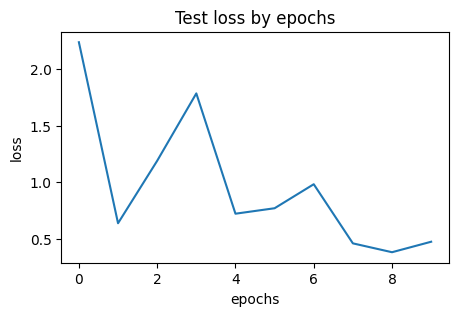

In [209]:
plt.figure(figsize=(5,3))
plt.plot([x[0] for x in res], [x[1].item() for x in res])
plt.title(f'Test loss by epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

In [210]:
# 모델 저장
torch.save(model, 'model.pth')
model_copy2 = torch.load('model.pth', weights_only=False)
model_copy2.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1924,  0.4206,  0.0592],
                        [-0.7938,  0.5811,  0.6010],
                        [-0.4346,  0.1175,  0.0938]],
              
                       [[-0.6921,  0.1305,  0.3105],
                        [-1.2510,  0.3471,  0.4612],
                        [-0.6583, -0.0564,  0.2419]],
              
                       [[-0.3601,  0.2828,  0.2790],
                        [-1.0123,  0.4958,  0.8163],
                        [-0.5308,  0.2395,  0.5568]]],
              
              
                      [[[ 1.1615, -0.9580, -0.2610],
                        [ 1.4248, -1.0153, -0.5677],
                        [-0.8670,  0.1001,  0.3588]],
              
                       [[ 1.1177, -0.7421, -0.0741],
                        [ 1.4143, -0.8610, -0.3775],
                        [-0.8677,  0.3469,  0.3843]],
              
                       [[ 0.7454, -0.9385,  0.0454],
                        [ 